<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/VQC_check_again.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

from IPython.display import clear_output
clear_output()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dis

0.8096
0.8032
0.8139
0.8088
0.7899
0.8134
0.8076
0.8041
0.8043
0.8094
0.8046
0.8004
0.7954
0.8026
0.7882
0.8076
0.8027
0.8000
0.8010
0.8023
0.7955
0.8100
0.7939
0.8061
0.8058
0.7997
0.7967
0.8010
0.7992
0.7953
0.8056
0.7906
0.7951
0.7981
0.8072
0.7909
0.7915
0.7905
0.8028
0.7980
0.7906
0.8147
0.7967
0.7932
0.8033
0.8044
0.7911
0.7974
0.7907
0.8005
0.7997
0.7981
0.7909
0.7933
0.7888
0.7867
0.7826
0.7971
0.7854
0.7888
0.7959
0.7941
0.8002
0.7921
0.7893
0.7824
0.7844
0.7863
0.7776
0.7829
0.8039
0.7752
0.7897
0.7931
0.7901
0.7894
0.7957
0.7789
0.7789
0.7756
0.7810
0.7803
0.7800
0.7841
0.7705
0.7745
0.7741
0.7790
0.7788
0.7709
0.7867
0.7824
0.7786
0.7812
0.7817
0.7775
0.7808
0.7810
0.7727
0.7907
0.7792
0.7909
0.7836
0.7729
0.7742
0.7811
0.7731
0.7740
0.7682
0.7771
0.7764
0.7712
0.7773
0.7686
0.7829
0.7800
0.7776
0.7681
0.7689
0.7748
0.7701
0.7714
0.7618
0.7783
0.7716
0.7731
0.7656
0.7667
0.7713
0.7720
0.7721
0.7757
0.7646
0.7658
0.7630
0.7860
0.7700
0.7670
0.7633
0.7782
0.7621
0.7634
0.7641

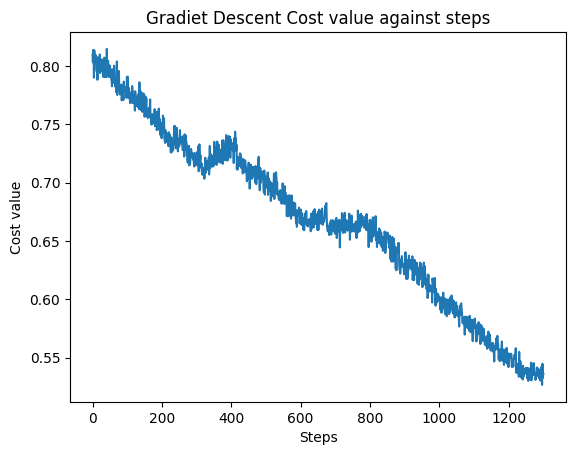

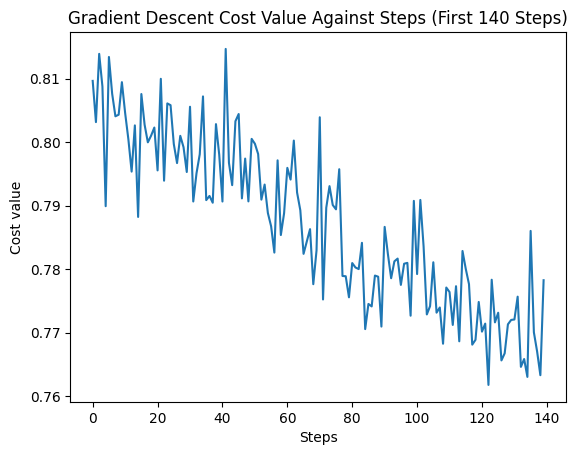

In [2]:
#from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers  import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit import transpile
#from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import VQC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False))

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)
circuit = FEATURE_MAP.compose(VAR_FORM)
circuit.draw()

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification

def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

cost_list = []
def cost_function(data, labels, variational,print_value=True):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    # Log the cost and parameters
    #log.update(len(cost_list), variational, cost, None, None)

    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

import csv
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, stepsize, accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
    def save_to_csv(self, filename='optimizer_log_GradientDescent100_adhoc.csv'):
        """Save evaluations and costs to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost'])
            for evaluation, cost in zip(self.evaluations, self.costs):
                writer.writerow([evaluation, cost])
        print(f"Optimizer log saved to {filename}")

# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
cost_list = []
#optimizer = SPSA(maxiter=50)
optimizer = GradientDescent(maxiter=100)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])
import time
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

start_time = time.time()
# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

opt_var = result.x
opt_value = result.fun
print()
print('opt_params:', opt_var)
print('opt_value: ', opt_value)

# Save optimization log to CSV
log.save_to_csv('optimizer_log_GradientDescent_100_adhoc.csv')

fig = plt.figure()
plt.plot(range(0,len(cost_list),1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("Gradiet Descent Cost value against steps")
plt.show()

fig = plt.figure()
plt.plot(range(0, min(len(cost_list), 140), 1), cost_list[:140])
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("Gradient Descent Cost Value Against Steps (First 140 Steps)")
plt.show()

0.9790
0.9947
0.9933
0.9848
0.9803
0.9897
0.9687
0.9970
0.9874
0.9795
0.9848
0.9856
0.9869
0.8968
Cost after layer 1: 0.8968165106406149, Learning Rate: 0.1
0.8996
0.9015
0.8886
0.8961
0.8961
0.8932
0.9025
0.8982
0.9057
0.9019
0.8918
0.9105
0.8961
0.9346
Cost after layer 2: 0.9345673505339762, Learning Rate: 0.095
0.9357
0.9339
0.9311
0.9335
0.9363
0.9473
0.9346
0.9386
0.9307
0.9268
0.9339
0.9373
0.9242
0.8845
Cost after layer 3: 0.8844931569381812, Learning Rate: 0.09025
0.8762
0.8865
0.8806
0.8939
0.8966
0.8882
0.8901
0.8872
0.8833
0.9066
0.8890
0.8860
0.8694
0.8572
Cost after layer 4: 0.8572004726110704, Learning Rate: 0.0857375
0.8650
0.8625
0.8488
0.8523
0.8564
0.8545
0.8387
0.8513
0.8503
0.8550
0.8617
0.8507
0.8546
0.8435
Cost after layer 5: 0.843496919505144, Learning Rate: 0.081450625
0.8296
0.8324
0.8375
0.8433
0.8472
0.8428
0.8388
0.8438
0.8298
0.8338
0.8386
0.8370
0.8470
0.8027
Cost after layer 6: 0.8027407985996865, Learning Rate: 0.07737809374999999
0.7964
0.7938
0.7954
0.

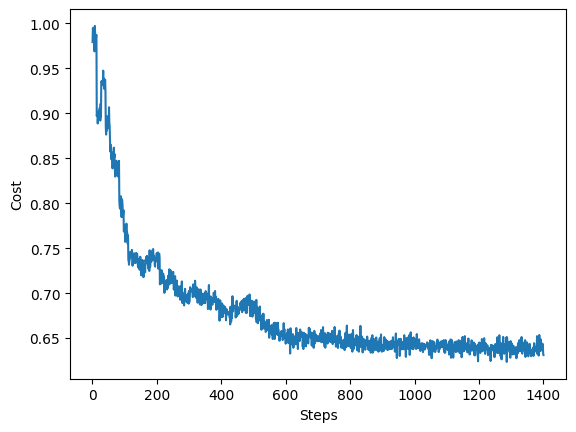

In [5]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import csv
import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)
cost_list=[]
def cost_function(data, labels, variational,print_value=True):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    cost_list.append(cost)

    log.update(len(cost_list), variational, cost, None, None)

    if print_value:
        print('%.4f' % cost)

    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, stepsize, accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
    def save_to_csv(self, filename='optimizer_log_dun.csv'):
        """Save evaluations and costs to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost'])
            for evaluation, cost in zip(self.evaluations, self.costs):
                writer.writerow([evaluation, cost])
        print(f"Optimizer log saved to {filename}")

# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = GradientDescent(maxiter=1)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization

# Define a dynamic learning rate function (example: exponential decay)
def dynamic_learning_rate(layer, initial_lr=0.1, decay_rate=0.95):
    return initial_lr * (decay_rate ** layer)

learning_rates=[]
# Deep Unfolding Training
num_layers = 100  # Number of layers (iterations) for deep unfolding
opt_var = initial_point
initial_lr = 0.1  # Initial learning rate

import time

start_time = time.time()
for layer in range(num_layers):
    # Adjust the learning rate for the current layer
    learning_rate = dynamic_learning_rate(layer, initial_lr)

    # Reinitialize optimizer with the current learning rate
    optimizer = GradientDescent(maxiter=1, learning_rate=learning_rate)

    result = optimizer.minimize(objective_function, opt_var)
    opt_var = result.x  # Update parameters for the next layer
    #log.update(layer, opt_var, result.fun)
    #log.update(layer, opt_var, result.fun, None, None)
    learning_rates.append(learning_rate)
    # Print the cost at each iteration
    print(f"Cost after layer {layer + 1}: {result.fun}, Learning Rate: {learning_rate}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Final optimized value and cost
opt_value = log.costs[-1]
opt_var = log.parameters[-1]
# After the optimization loop
log.save_to_csv('optimizer_log_dun.csv')
#result = optimizer.minimize(objective_function, initial_point)

#opt_var = result.x
#opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Suggestion 01:

Without recording all the cost in log, will try to log final layer output and optimize accordingly for next version, To draw all the cost , will save it into costs=[] array and then draw a plot.

suggestion 02:
 Let's grab the lowest cost per layer(from in between cost values) then start optimization accordingly. Try this next

0.9780
0.9763
0.9851
0.9957
0.9819
0.9931
0.9778
0.9927
0.9913
0.9915
0.9821
0.9757
0.9806
0.9488
Cost after layer 1: 0.9488338398811667, Learning Rate: 0.1
0.9555
0.9513
0.9582
0.9525
0.9405
0.9537
0.9513
0.9628
0.9514
0.9509
0.9533
0.9417
0.9474
0.9760
Cost after layer 2: 0.9759716497072602, Learning Rate: 0.095
0.9742
0.9671
0.9625
0.9771
0.9782
0.9805
0.9645
0.9606
0.9650
0.9679
0.9690
0.9709
0.9617
0.9572
Cost after layer 3: 0.9571773703623032, Learning Rate: 0.09025
0.9587
0.9543
0.9617
0.9539
0.9611
0.9618
0.9504
0.9535
0.9472
0.9602
0.9542
0.9600
0.9428
0.9282
Cost after layer 4: 0.9281504452413161, Learning Rate: 0.0857375
0.9232
0.9307
0.9382
0.9232
0.9302
0.9220
0.9241
0.9231
0.9298
0.9044
0.9155
0.9359
0.9140
0.9229
Cost after layer 5: 0.9228941852638899, Learning Rate: 0.081450625
0.9227
0.9160
0.9199
0.9078
0.9112
0.9024
0.9061
0.9266
0.9209
0.9243
0.9204
0.9192
0.9131
0.9552
Cost after layer 6: 0.9551728981052594, Learning Rate: 0.07737809374999999
0.9625
0.9472
0.9452
0

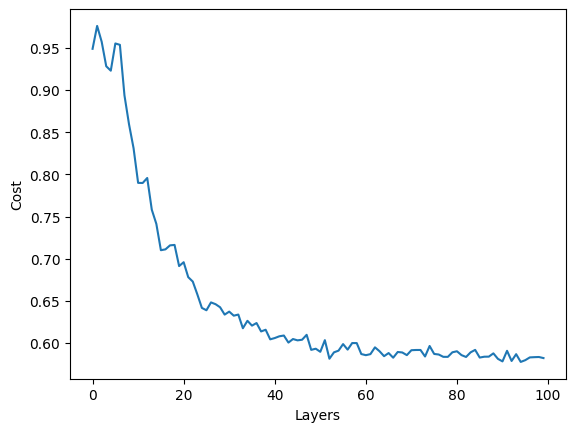

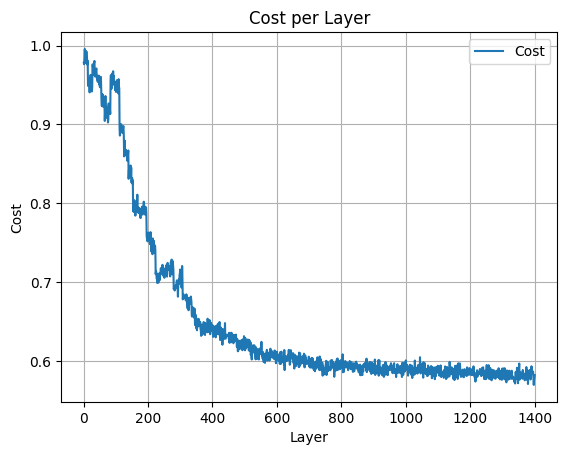

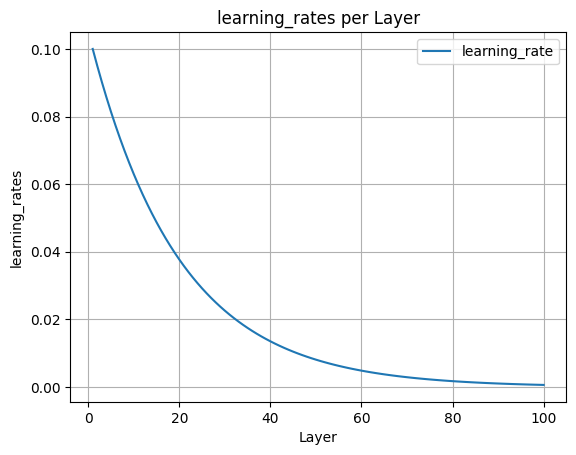

In [8]:
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import csv
import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False)
)
# ZZfeatureMap for data encoding a
# Two Local for variational circuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#We create a function that associates the data to the feature map and the variational parameters to the variational circuit.
#This is to ensure that the right parameters
#in the circuit are associated with the right quantities.

def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

from qiskit_aer import Aer
from qiskit import transpile # Import execute from qiskit


def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = Aer.get_backend('qasm_simulator')
    # Transpile and execute each circuit individually
    results = []
    for circuit in circuits:
        t_circuit = transpile(circuit, backend)
        result = backend.run(t_circuit).result() # Execute each transpiled circuit
        results.append(result)
    classification = [
        label_probability(result.get_counts()) for result in results] # Get counts from each result
    return classification


def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)
cost_list=[]
def cost_function(data, labels, variational,print_value=True):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    cost_list.append(cost)

    #log.update(len(cost_list), variational, cost, None, None)

    if print_value:
        print('%.4f' % cost)

    return cost

class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        self.step_sizes = []  # Add a list to store step sizes
    def update(self, evaluation, parameter, cost, stepsize, accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        self.step_sizes.append(stepsize)  # Store the step size
    def save_to_csv(self, filename='optimizer_log_dun.csv'):
        """Save evaluations, costs, and step sizes to a CSV file."""
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Evaluation', 'Cost', 'Step Size'])
            for evaluation, cost, step_size in zip(self.evaluations, self.costs, self.step_sizes):
                writer.writerow([evaluation, cost, step_size])
        print(f"Optimizer log saved to {filename}")


# Set up the optimization
from qiskit_algorithms.optimizers import GradientDescent
#from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = GradientDescent(maxiter=1)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization

# Define a dynamic learning rate function (example: exponential decay)
def dynamic_learning_rate(layer, initial_lr=0.1, decay_rate=0.95):
    return initial_lr * (decay_rate ** layer)

learning_rates=[]
# Deep Unfolding Training
num_layers = 100  # Number of layers (iterations) for deep unfolding
opt_var = initial_point
initial_lr = 0.1  # Initial learning rate

import time

start_time = time.time()
for layer in range(num_layers):
    # Adjust the learning rate for the current layer
    learning_rate = dynamic_learning_rate(layer, initial_lr)

    # Reinitialize optimizer with the current learning rate
    optimizer = GradientDescent(maxiter=1, learning_rate=learning_rate)

    result = optimizer.minimize(objective_function, opt_var)
    opt_var = result.x  # Update parameters for the next layer
    #log.update(layer, opt_var, result.fun)
    log.update(layer, opt_var, result.fun, None, None)
    learning_rates.append(learning_rate)
    # Print the cost at each iteration
    print(f"Cost after layer {layer + 1}: {result.fun}, Learning Rate: {learning_rate}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Final optimized value and cost
opt_value = log.costs[-1]
opt_var = log.parameters[-1]
# After the optimization loop
log.save_to_csv('optimizer_log_dun.csv')
#result = optimizer.minimize(objective_function, initial_point)

#opt_var = result.x
#opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Layers')
plt.ylabel('Cost')
plt.show()


# Plot the costs recorded in cost_list
plt.plot(range(1, len(cost_list) + 1), cost_list, label='Cost')
plt.xlabel('Layer')
plt.ylabel('Cost')
plt.title('Cost per Layer')
plt.legend()
plt.grid(True)
plt.show()

# Plot the costs recorded in cost_list
plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='learning_rate')
plt.xlabel('Layer')
plt.ylabel('learning_rates')
plt.title('learning_rates per Layer')
plt.legend()
plt.grid(True)
plt.show()

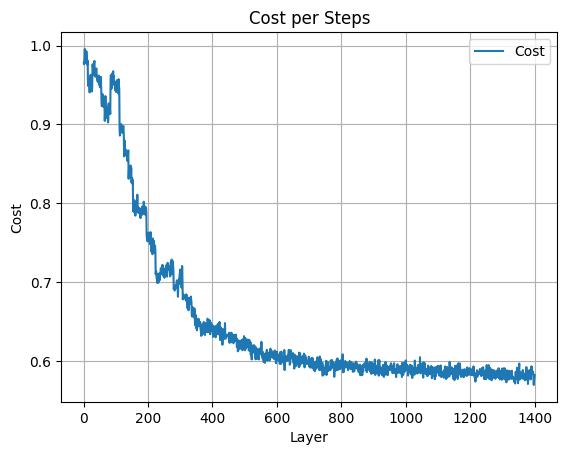

In [9]:
# Plot the costs recorded in cost_list
plt.plot(range(1, len(cost_list) + 1), cost_list, label='Cost')
plt.xlabel('Layer')
plt.ylabel('Cost')
plt.title('Cost per Steps')
plt.legend()
plt.grid(True)
plt.show()